In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## IMPORT RELEVANT LIBRARIES



In [ ]:
import numpy as np
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import time
import matplotlib.pyplot as plt

## DECLARING CONSTANTS

In [ ]:
# FIXED CONSTANTS
WORD_LIMIT = 500000
LENGTH = 50 + 1  # input seed (50) + predicted output (1)
NO_OF_OUTPUT_WORDS = 30  # number of text predicted/generated

# file paths of the dataset
DATA = ["SgCorpus"]
COLAB_FILEPATH = './drive/My Drive/next-sentence-predictor/finalData/'
WEIGHTS_DIR = './drive/My Drive/next-sentence-predictor/saved_weights/'

## LOAD & PREPROCESS THE DATA

In [ ]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    text = text.lower()
    # close the file
    file.close()
    return text

In [ ]:
# DECLARE THE FINAL FILEPATH TO LOAD THE DATA
filename = COLAB_FILEPATH + DATA[0] + '.txt'
# CALL FUNCTION TO LOAD RAW DATA
data = load_doc(filename)
# PREVIEW SOME TEXT FROM THE RAW DATA
print(data[250:650])  

ay. she's really sweet and cute, especially when she laughs does anyone know who she is? i really want to get to know her before vday 
why do not they let the crashers play orientation games this year? suddenly so strict 
anyone knows that sassy indian girl from neytiri? she is so cute 
does anyone know the guy from acs in atom?? he's 1.7m plus and is quite fair-skinned and skinny.anonymous admin:


In [ ]:
# FUNCTION TO FURTHER CLEAN THE SCRAPED DATASET
def clean_txt(doc):
  tokens = doc.split()
  table = str.maketrans('','',string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word.lower() for word in tokens]
  return tokens

In [ ]:
# PASS THE RAW DATA INTO THE FUNCTION
tokens = clean_txt(data)
print(tokens[50:100])

['especially', 'when', 'she', 'laughs', 'does', 'anyone', 'know', 'who', 'she', 'is', 'i', 'really', 'want', 'to', 'get', 'to', 'know', 'her', 'before', 'vday', 'why', 'do', 'not', 'they', 'let', 'the', 'crashers', 'play', 'orientation', 'games', 'this', 'year', 'suddenly', 'so', 'strict', 'anyone', 'knows', 'that', 'sassy', 'indian', 'girl', 'from', 'neytiri', 'she', 'is', 'so', 'cute', 'does', 'anyone', 'know']


In [ ]:
# CHECK THE NUMBER OF WORDS (NOT UNIQUE) IN THE SCRAPED CORPUS
len(tokens)

3968494

In [ ]:
# NUMBER OF UNIQUE WORDS IN THE CORPUS
len(set(tokens))

116676

In [ ]:
# GET WORD SEQUENCES
lines = list()
for i in range(LENGTH, len(tokens),2): # skip a word for each word sequences
  seq = tokens[i-LENGTH:i]
  line = ' '.join(seq)
  lines.append(line)
  # resource constraint (colab RAM), 
  # take only the first (number of words =  WORD_LIMIT) it encounters
  if i > WORD_LIMIT:
    break

print(len(lines))

249976


In [ ]:
# PREVIEW A PARTICULAR WORD SEQUENCE
lines[350]

'sense of belonging yet in doing so we leave the unlucky ones out almost as if they do not have the same human needs as usi am not a saint i have judged people from ac based on their actions and character traits nonetheless this issue has to be discussed and'

## BULID MODELS AND PREPARE X AND y (sentence input & word output)

In [ ]:
# TOKENIZE TEXT SEQUENCE
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

# convert to numpy array
sequences = np.array(sequences)

# assign X and y
X, y = sequences[:,:-1], sequences[:,-1]

# looking at the word embedding
#print(X[111])

# output
#print(y[111])

# SIZE OF THE VOCAB
vocab_size = len(tokenizer.word_index) + 1
#vocab_size

# one-hot the output y
y = to_categorical(y, num_classes=vocab_size, dtype='int8')

# GET THE SEQUENCE LENGTH
seq_length = X.shape[1]
#seq_length

# OUTPUT DIMENSION OF THE EMBEDDING LAYER
EM_OUTPUT_LENGTH = 50

# HELPER FUNCTIONS
### These are functions that will be used to:
-> Train the model   
-> Load the pre-trained H5 files   
-> Generate text sequence   
-> Show generated text  
-> Load the .csv files created from the CSVlogger to plot a training loss vs epochs graph

In [ ]:
# TRAIN THE MODEL
# Write a function to run different variant of the model
def fit_model(model_type, optimizer_type, batch_size, X, y, model_name, epochs):
    model = Sequential()
    model.add(Embedding(vocab_size, EM_OUTPUT_LENGTH, input_length=seq_length))
    if model_type == "LSTM":
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
    elif model_type == "GRU":
        model.add(GRU(128, return_sequences=True))
        model.add(GRU(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))

    if optimizer_type == "Adam":
        optimizer = Adam(learning_rate=0.001)
    # using SGD don't seem to converge well for this case
    elif optimizer_type == "SGD":
        optimizer = SGD(learning_rate=0.001, momentum = 0.1)
    elif optimizer_type == "RMSprop":
        optimizer = RMSprop(learning_rate=0.001, momentum = 0.1)

    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    # save the weights for different configuration
    filepath = f"{WEIGHTS_DIR}/{model_name}-{epochs}_epoch-{batch_size}_batch_size-{optimizer_type}"

    csv_logger = CSVLogger(filepath+".csv",append=False,separator=',')
    checkpoint = ModelCheckpoint(filepath+".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=1, min_lr=1e-8)
    early_stopping = EarlyStopping(monitor='loss',
                                    mode='min',
                                    verbose=1,
                                    patience=5)
    desired_callbacks = [checkpoint, early_stopping, csv_logger, reduce_lr]
    start = time.perf_counter()
    model.fit(X, y, 
              batch_size = batch_size, 
              epochs = epochs, 
              callbacks=desired_callbacks)
    time_taken = time.perf_counter() - start
    #print(f"Total time taken for {epochs} epochs: {time_taken} seconds")
    #print(f"Average time taken per epochs: {time_taken/epochs} seconds")
    print(f"Total time taken to train: {time_taken} seconds")

    return model

In [ ]:
# LOAD PRE-TRAINED H5 FILES
# Write a function to load different variant of the pre-trained model
def load_pretrain_model(model_name,batch_size,epochs, optimizer_type):
    filepath = f"{WEIGHTS_DIR}{model_name}-{epochs}_epoch-{batch_size}_batch_size-{optimizer_type}.h5"
    # debug
    #print(filepath)

    # load the model
    model = load_model(filepath)
    #model.summary()

    return model

In [ ]:
# GENERATE TEXT SEQUENCES
def generate_text_seq(model, tokenizer, text_seq_length, seed_text, n_words):
  text = list()

  for _ in range(n_words):
    # [0] - 0th dimension of the array which contains the encoded text (number tag)
    encoded = tokenizer.texts_to_sequences([seed_text])[0] 
    encoded = pad_sequences([encoded], maxlen = text_seq_length, truncating='pre')

    # predict the probability of each word
    #y_pred = model.predict_classes(encoded)
    y_pred = np.argmax(model.predict(encoded), axis=-1)

    predicted_word = ''
    for word, index in tokenizer.word_index.items():
      if index == y_pred:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)

  return ' '.join(text)

In [ ]:
# SHOW GENERATED TEXT
def show_generated_text(model, tokenizer, seq_length, no_of_output_words, own_text="eating and sleeping",seed=12345):
    # SEED TEXT GOTTEN FROM THE CORPUS
    seed_text_from_corpus = lines[seed]
    #print(f"seed_text_from_corpus: {seed_text_from_corpus}")
    #print()

    # OUR OWN SEED TEXT
    seed_text_own = own_text
    #print(seed_text_own)

    # generate next N words after seed text
    # seed text from corpus
    #var_corpus = generate_text_seq(model, tokenizer, seq_length, seed_text_from_corpus, no_of_output_words)
    #print("Text generated from corpus seed text:")
    #print(f"{seed_text_from_corpus} -> {var_corpus}")

    #print()

    # seed text from own text
    var_own = generate_text_seq(model, tokenizer, seq_length, seed_text_own, no_of_output_words)
    print("Text generated from own seed text:")
    print(f"{seed_text_own} {var_own}")
    full_sentence = seed_text_own + " " + var_own
    
    return full_sentence

In [ ]:
# Load the .csv files created from the CSVlogger to plot a training loss vs epochs graph
def load_saved_csv(model_name="2LAYER_LSTM", epochs=20, batch_size=128, optimizer_type="Adam"):
    data = np.genfromtxt(f'{WEIGHTS_DIR}{model_name}-{epochs}_epoch-{batch_size}_batch_size-{optimizer_type}.csv', delimiter=',')
    epoch_count, training_loss = data[1:,0].astype(int), data[1:,-1]
    # change epoch count from 0-99 to 1-100
    epoch_count += 1
    
    return epoch_count, training_loss

# TRAIN THE MODEL

#### In total, there will be 10 models that we will be training here, including 2 failed models for report and testing purposes
-> Stacked LSTM + Adam + 1 Epoch + Batch Size 128 [TESTING PURPOSES]  
-> Stacked LSTM + Adam + 20 Epochs + Batch Size 128 [TESTING PURPOSES]   
-> Stacked LSTM + SGD + Momentum + 20 Epochs + Batch Size 128 [TESTING PURPOSES]   
-> Stacked LSTM + Adam + 100 Epochs + Batch Size 128   
-> Stacked LSTM + RMSprop + 100 Epochs + Batch Size 128   
-> Stacked GRU + Adam + 100 Epochs + Batch Size 128   
-> Stacked GRU + RMSprop + 100 Epochs + Batch Size 128  
-> Stacked LSTM + Adam + 100 Epochs + Batch Size 64  
-> Stacked LSTM + RMSprop + 100 Epochs + Batch Size 64  
-> Stacked GRU + Adam + 100 Epochs + Batch Size 64  
-> Stacked GRU + RMSprop + 100 Epochs + Batch Size 64  


WARNING: Only train one model at one instance due to the lack of resources of colab


In [ ]:
# initialise number of epochs to train the model
EPOCHS = 100

In [ ]:
# LSTM + Adam + 1 Epoch + Batch Size 128 [FAILED EXAMPLE]  
model = fit_model(model_type="LSTM", optimizer_type="Adam", batch_size=128, X=X, y=y, model_name="2LAYER_LSTM", epochs=1)

1952/1953 [============================>.] - ETA: 0s - loss: 7.4448 - accuracy: 0.0339
Epoch 00001: loss improved from inf to 7.44456, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-1_epoch-128_batch_size-Adam.h5
1953/1953 [==============================] - 67s 34ms/step - loss: 7.4446 - accuracy: 0.0339
Total time taken for 1 epochs: 69.76227437600005 seconds
Average time taken per epochs: 69.76227437600005 seconds


In [ ]:
# LSTM + Adam + 20 Epochs + Batch Size 128 [FAILED EXAMPLE] 
model = fit_model(model_type="LSTM", optimizer_type="Adam", batch_size=128, X=X, y=y, model_name="2LAYER_LSTM", epochs=20)

Epoch 1/20
1953/1953 [==============================] - ETA: 0s - loss: 7.4202 - accuracy: 0.0354
Epoch 00001: loss improved from inf to 7.42024, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-20_epoch-128_batch_size-Adam.h5
1953/1953 [==============================] - 66s 34ms/step - loss: 7.4202 - accuracy: 0.0354
Epoch 2/20
1953/1953 [==============================] - ETA: 0s - loss: 6.8278 - accuracy: 0.0583
Epoch 00002: loss improved from 7.42024 to 6.82781, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-20_epoch-128_batch_size-Adam.h5
1953/1953 [==============================] - 66s 34ms/step - loss: 6.8278 - accuracy: 0.0583
Epoch 3/20
1952/1953 [============================>.] - ETA: 0s - loss: 6.4368 - accuracy: 0.0859
Epoch 00003: loss improved from 6.82781 to 6.43678, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-20_epoch-128_batch_size-Adam.h5
1953/1953 [============

In [ ]:
# LSTM + SGD + Momentum + 20 Epochs + Batch Size 128 [FAILED EXAMPLE]
model = fit_model(model_type="LSTM", optimizer_type="SGD", batch_size=128, X=X, y=y, model_name="2LAYER_LSTM", epochs=20)

Epoch 1/20
1951/1953 [============================>.] - ETA: 0s - loss: 10.4004 - accuracy: 0.0314
Epoch 00001: loss improved from inf to 10.40035, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-20_epoch-128_batch_size-SGD.h5
1953/1953 [==============================] - 43s 22ms/step - loss: 10.4003 - accuracy: 0.0314
Epoch 2/20
1952/1953 [============================>.] - ETA: 0s - loss: 10.3890 - accuracy: 0.0316
Epoch 00002: loss improved from 10.40035 to 10.38897, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-20_epoch-128_batch_size-SGD.h5
1953/1953 [==============================] - 43s 22ms/step - loss: 10.3890 - accuracy: 0.0316
Epoch 3/20
1951/1953 [============================>.] - ETA: 0s - loss: 10.3775 - accuracy: 0.0316
Epoch 00003: loss improved from 10.38897 to 10.37754, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-20_epoch-128_batch_size-SGD.h5
1953/1953 [=====

In [ ]:
# LSTM + Adam + 100 Epochs + Batch Size 128  
model = fit_model(model_type="LSTM", optimizer_type="Adam", batch_size=128, X=X, y=y, model_name="2LAYER_LSTM", epochs=EPOCHS)

Epoch 1/100
1953/1953 [==============================] - ETA: 0s - loss: 7.4089 - accuracy: 0.0364
Epoch 00001: loss improved from inf to 7.40890, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-128_batch_size-Adam.h5
1953/1953 [==============================] - 66s 34ms/step - loss: 7.4089 - accuracy: 0.0364
Epoch 2/100
1953/1953 [==============================] - ETA: 0s - loss: 6.8128 - accuracy: 0.0602
Epoch 00002: loss improved from 7.40890 to 6.81280, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-128_batch_size-Adam.h5
1953/1953 [==============================] - 66s 34ms/step - loss: 6.8128 - accuracy: 0.0602
Epoch 3/100
1953/1953 [==============================] - ETA: 0s - loss: 6.4181 - accuracy: 0.0854
Epoch 00003: loss improved from 6.81280 to 6.41805, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-128_batch_size-Adam.h5
1953/1953 [======

In [ ]:
# LSTM + RMSprop + 100 Epochs + Batch Size 128  
model = fit_model(model_type="LSTM", optimizer_type="RMSprop", batch_size=128, X=X, y=y, model_name="2LAYER_LSTM", epochs=EPOCHS)

Epoch 1/100
1951/1953 [============================>.] - ETA: 0s - loss: 7.5627 - accuracy: 0.0306
Epoch 00001: loss improved from inf to 7.56273, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-128_batch_size-RMSprop.h5
1953/1953 [==============================] - 44s 23ms/step - loss: 7.5627 - accuracy: 0.0306
Epoch 2/100
1952/1953 [============================>.] - ETA: 0s - loss: 7.4796 - accuracy: 0.0319
Epoch 00002: loss improved from 7.56273 to 7.47963, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-128_batch_size-RMSprop.h5
1953/1953 [==============================] - 45s 23ms/step - loss: 7.4796 - accuracy: 0.0319
Epoch 3/100
1953/1953 [==============================] - ETA: 0s - loss: 7.2420 - accuracy: 0.0451
Epoch 00003: loss improved from 7.47963 to 7.24196, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-128_batch_size-RMSprop.h5
1953/195

In [ ]:
# GRU + Adam + 100 Epochs + Batch Size 128  
model = fit_model(model_type="GRU", optimizer_type="Adam", batch_size=128, X=X, y=y, model_name="2LAYER_GRU", epochs=EPOCHS)

Epoch 1/100
1953/1953 [==============================] - ETA: 0s - loss: 7.5443 - accuracy: 0.0308
Epoch 00001: loss improved from inf to 7.54428, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-128_batch_size-Adam.h5
1953/1953 [==============================] - 67s 34ms/step - loss: 7.5443 - accuracy: 0.0308
Epoch 2/100
1953/1953 [==============================] - ETA: 0s - loss: 7.3298 - accuracy: 0.0312
Epoch 00002: loss improved from 7.54428 to 7.32983, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-128_batch_size-Adam.h5
1953/1953 [==============================] - 66s 34ms/step - loss: 7.3298 - accuracy: 0.0312
Epoch 3/100
1953/1953 [==============================] - ETA: 0s - loss: 7.3180 - accuracy: 0.0314
Epoch 00003: loss improved from 7.32983 to 7.31800, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-128_batch_size-Adam.h5
1953/1953 [=========

In [ ]:
# GRU + RMSprop + 100 Epochs + Batch Size 128  
model = fit_model(model_type="GRU", optimizer_type="RMSprop", batch_size=128, X=X, y=y, model_name="2LAYER_GRU", epochs=EPOCHS)

Epoch 1/100
1951/1953 [============================>.] - ETA: 0s - loss: 7.5549 - accuracy: 0.0307
Epoch 00001: loss improved from inf to 7.55492, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-128_batch_size-RMSprop.h5
1953/1953 [==============================] - 43s 22ms/step - loss: 7.5549 - accuracy: 0.0308
Epoch 2/100
1953/1953 [==============================] - ETA: 0s - loss: 7.5103 - accuracy: 0.0315
Epoch 00002: loss improved from 7.55492 to 7.51033, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-128_batch_size-RMSprop.h5
1953/1953 [==============================] - 43s 22ms/step - loss: 7.5103 - accuracy: 0.0315
Epoch 3/100
1953/1953 [==============================] - ETA: 0s - loss: 7.5196 - accuracy: 0.0315
Epoch 00003: loss did not improve from 7.51033
1953/1953 [==============================] - 42s 22ms/step - loss: 7.5196 - accuracy: 0.0315
Epoch 4/100
1953/1953 [==================

In [ ]:
# LSTM + Adam + 100 Epochs + Batch Size 64  
model = fit_model(model_type="LSTM", optimizer_type="Adam", batch_size=64, X=X, y=y, model_name="2LAYER_LSTM", epochs=EPOCHS)

Epoch 1/100
3905/3906 [============================>.] - ETA: 0s - loss: 7.3779 - accuracy: 0.0392
Epoch 00001: loss improved from inf to 7.37781, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-64_batch_size-Adam.h5
3906/3906 [==============================] - 117s 30ms/step - loss: 7.3778 - accuracy: 0.0392
Epoch 2/100
3905/3906 [============================>.] - ETA: 0s - loss: 6.7042 - accuracy: 0.0720
Epoch 00002: loss improved from 7.37781 to 6.70423, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-64_batch_size-Adam.h5
3906/3906 [==============================] - 117s 30ms/step - loss: 6.7042 - accuracy: 0.0720
Epoch 3/100
3905/3906 [============================>.] - ETA: 0s - loss: 6.4399 - accuracy: 0.0883
Epoch 00003: loss improved from 6.70423 to 6.43995, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-64_batch_size-Adam.h5
3906/3906 [=======

In [ ]:
# LSTM + RMSprop + 100 Epochs + Batch Size 64 
model = fit_model(model_type="LSTM", optimizer_type="RMSprop", batch_size=64, X=X, y=y, model_name="2LAYER_LSTM", epochs=EPOCHS)

Epoch 1/100
3904/3906 [============================>.] - ETA: 0s - loss: 7.6359 - accuracy: 0.0307
Epoch 00001: loss improved from inf to 7.63586, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-64_batch_size-RMSprop.h5
3906/3906 [==============================] - 74s 19ms/step - loss: 7.6359 - accuracy: 0.0307
Epoch 2/100
3904/3906 [============================>.] - ETA: 0s - loss: 7.4768 - accuracy: 0.0395
Epoch 00002: loss improved from 7.63586 to 7.47682, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-64_batch_size-RMSprop.h5
3906/3906 [==============================] - 74s 19ms/step - loss: 7.4768 - accuracy: 0.0395
Epoch 3/100
3906/3906 [==============================] - ETA: 0s - loss: 7.2261 - accuracy: 0.0627
Epoch 00003: loss improved from 7.47682 to 7.22606, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_LSTM-100_epoch-64_batch_size-RMSprop.h5
3906/3906 [

In [ ]:
# GRU + Adam + 100 Epochs + Batch Size 64  
model = fit_model(model_type="GRU", optimizer_type="Adam", batch_size=64, X=X, y=y, model_name="2LAYER_GRU", epochs=EPOCHS)

Epoch 1/100
3906/3906 [==============================] - ETA: 0s - loss: 7.5613 - accuracy: 0.0311
Epoch 00001: loss improved from inf to 7.56134, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-64_batch_size-Adam.h5
3906/3906 [==============================] - 114s 29ms/step - loss: 7.5613 - accuracy: 0.0311
Epoch 2/100
3905/3906 [============================>.] - ETA: 0s - loss: 7.3365 - accuracy: 0.0314
Epoch 00002: loss improved from 7.56134 to 7.33642, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-64_batch_size-Adam.h5
3906/3906 [==============================] - 115s 29ms/step - loss: 7.3364 - accuracy: 0.0314
Epoch 3/100
3906/3906 [==============================] - ETA: 0s - loss: 7.2225 - accuracy: 0.0339
Epoch 00003: loss improved from 7.33642 to 7.22250, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-64_batch_size-Adam.h5
3906/3906 [==========

In [ ]:
# GRU + RMSprop + 100 Epochs + Batch Size 64 
model = fit_model(model_type="GRU", optimizer_type="RMSprop", batch_size=64, X=X, y=y, model_name="2LAYER_GRU", epochs=EPOCHS)

Epoch 1/100
3905/3906 [============================>.] - ETA: 0s - loss: 7.6432 - accuracy: 0.0312
Epoch 00001: loss improved from inf to 7.64310, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-64_batch_size-RMSprop.h5
3906/3906 [==============================] - 76s 19ms/step - loss: 7.6431 - accuracy: 0.0312
Epoch 2/100
3904/3906 [============================>.] - ETA: 0s - loss: 7.6426 - accuracy: 0.0313
Epoch 00002: loss improved from 7.64310 to 7.64248, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-64_batch_size-RMSprop.h5
3906/3906 [==============================] - 74s 19ms/step - loss: 7.6425 - accuracy: 0.0313
Epoch 3/100
3905/3906 [============================>.] - ETA: 0s - loss: 7.5805 - accuracy: 0.0344
Epoch 00003: loss improved from 7.64248 to 7.58061, saving model to ./drive/My Drive/next-sentence-predictor/saved_weights/2LAYER_GRU-100_epoch-64_batch_size-RMSprop.h5
3906/3906 [===

## Load the epoch and the loss value to do a training loss vs epoch plot
We will only load the csv files for the 100 epochs model, which are the actual models (no testing models included)

In [ ]:
# Initialise list to store all the loss values and epochs for all the models at the given epoch
training_loss_list = list()
epoch_count_list = list()

In [ ]:
# Load CSV for stacked LSTM + Adam + 100 Epoch + Batch Size 128
epoch_count, training_loss = load_saved_csv(model_name="2LAYER_LSTM", epochs=EPOCHS, batch_size=128, optimizer_type="Adam")
# store the training loss into the training loss list
training_loss_list.append(training_loss)
# store the epoch count into the epoch count list
epoch_count_list.append(epoch_count)

In [ ]:
# Load CSV for stacked LSTM + RMSprop + 100 Epoch + Batch Size 128
epoch_count, training_loss = load_saved_csv(model_name="2LAYER_LSTM", epochs=EPOCHS, batch_size=128, optimizer_type="RMSprop")
# store the training loss into the training loss list
training_loss_list.append(training_loss)
# store the epoch count into the epoch count list
epoch_count_list.append(epoch_count)

In [ ]:
# Load CSV for stacked GRU + Adam + 100 Epoch + Batch Size 128
epoch_count, training_loss = load_saved_csv(model_name="2LAYER_GRU", epochs=EPOCHS, batch_size=128, optimizer_type="Adam")
# store the training loss into the training loss list
training_loss_list.append(training_loss)
# store the epoch count into the epoch count list
epoch_count_list.append(epoch_count)

In [ ]:
# Load CSV for stacked GRU + RMSprop + 100 Epoch + Batch Size 128
epoch_count, training_loss = load_saved_csv(model_name="2LAYER_GRU", epochs=EPOCHS, batch_size=128, optimizer_type="RMSprop")
# store the training loss into the training loss list
training_loss_list.append(training_loss)
# store the epoch count into the epoch count list
epoch_count_list.append(epoch_count)

In [ ]:
# Load CSV for stacked LSTM + Adam + 100 Epoch + Batch Size 64
epoch_count, training_loss = load_saved_csv(model_name="2LAYER_LSTM", epochs=EPOCHS, batch_size=64, optimizer_type="Adam")
# store the training loss into the training loss list
training_loss_list.append(training_loss)
# store the epoch count into the epoch count list
epoch_count_list.append(epoch_count)

In [ ]:
# Load CSV for stacked LSTM + RMSprop + 100 Epoch + Batch Size 64
epoch_count, training_loss = load_saved_csv(model_name="2LAYER_LSTM", epochs=EPOCHS, batch_size=64, optimizer_type="RMSprop")
# store the training loss into the training loss list
training_loss_list.append(training_loss)
# store the epoch count into the epoch count list
epoch_count_list.append(epoch_count)

In [ ]:
# Load CSV for stacked GRU + Adam + 100 Epoch + Batch Size 64
epoch_count, training_loss = load_saved_csv(model_name="2LAYER_GRU", epochs=EPOCHS, batch_size=64, optimizer_type="Adam")
# store the training loss into the training loss list
training_loss_list.append(training_loss)
# store the epoch count into the epoch count list
epoch_count_list.append(epoch_count)

In [ ]:
# Load CSV for stacked GRU + RMSprop + 100 Epoch + Batch Size 64
epoch_count, training_loss = load_saved_csv(model_name="2LAYER_GRU", epochs=EPOCHS, batch_size=64, optimizer_type="RMSprop")
# store the training loss into the training loss list
training_loss_list.append(training_loss)
# store the epoch count into the epoch count list
epoch_count_list.append(epoch_count)

In [ ]:
# Do sanity check for the length of each list
len(training_loss_list) == len(epoch_count_list) == 8

True

In [ ]:
# dimension of the plot
WIDTH = 25
HEIGHT = 15

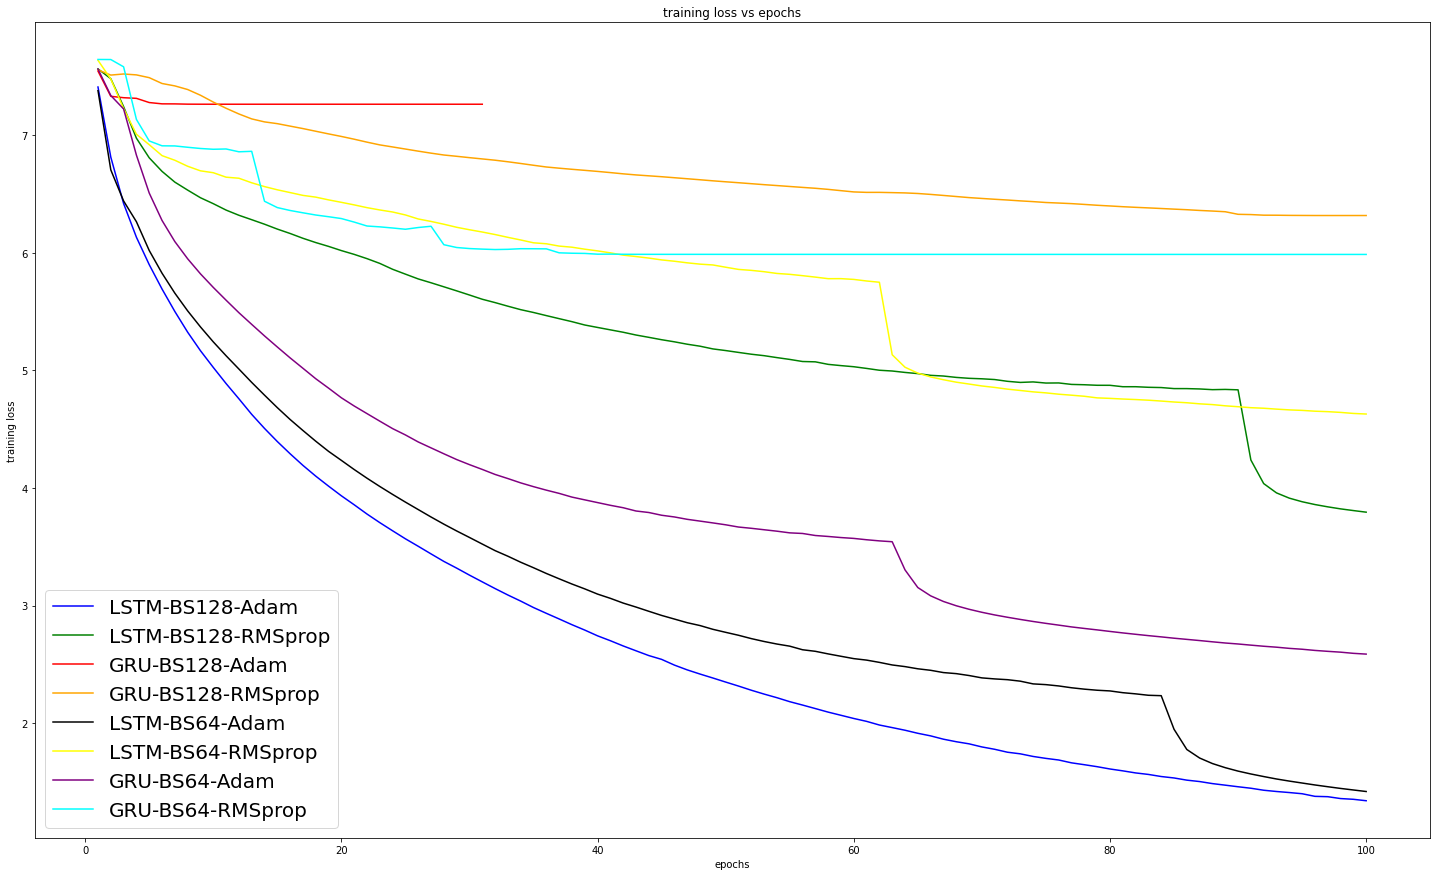

In [ ]:
# plot the training loss for all 8 models
plt.figure(figsize=(WIDTH,HEIGHT))
plt.title("training loss vs epochs")
plt.plot(epoch_count_list[0],training_loss_list[0],'blue',label='LSTM-BS128-Adam')
plt.plot(epoch_count_list[1],training_loss_list[1],'green',label='LSTM-BS128-RMSprop')
plt.plot(epoch_count_list[2],training_loss_list[2],'red',label='GRU-BS128-Adam')
plt.plot(epoch_count_list[3],training_loss_list[3],'orange',label='GRU-BS128-RMSprop')
plt.plot(epoch_count_list[4],training_loss_list[4],'black',label='LSTM-BS64-Adam')
plt.plot(epoch_count_list[5],training_loss_list[5],'yellow',label='LSTM-BS64-RMSprop')
plt.plot(epoch_count_list[6],training_loss_list[6],'purple',label='GRU-BS64-Adam')
plt.plot(epoch_count_list[7],training_loss_list[7],'cyan',label='GRU-BS64-RMSprop')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.legend(loc="best", prop={'size': 20})

# LOAD PRE-TRAINED H5 FILE & SHOW GENERATED TEXT

In [ ]:
# initialise number of epochs to train the model
EPOCHS = 100
# initialise the starting word/phrase of our own text and seed count
OWN_TEXT_STARTER = "i came to see"
SEED = 1234

In [ ]:
# LSTM + Adam + 1 Epoch + Batch Size 128 [TESTING]  
model = load_pretrain_model(model_name="2LAYER_LSTM", batch_size=128, epochs=1, optimizer_type="Adam")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see to the the the the and and the the and and the and and and and and and and and and and and and and and and and and and


In [ ]:
# LSTM + Adam + 20 Epochs + Batch Size 128 [TESTING] 
model = load_pretrain_model(model_name="2LAYER_LSTM", batch_size=128, epochs=20, optimizer_type="Adam")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see you guys to be able to get a best for the school in the end of the school was a levels and i am not a crush on my og


In [ ]:
# LSTM + SGD + momentum + 100 Epochs + Batch Size 128 [TESTING]
model = load_pretrain_model(model_name="2LAYER_LSTM", batch_size=128, epochs=20, optimizer_type="SGD")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


In [ ]:
# LSTM + Adam + 100 Epochs + Batch Size 128  
model = load_pretrain_model(model_name="2LAYER_LSTM", batch_size=128, epochs=EPOCHS, optimizer_type="Adam")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see you feel we have chris rich ah oh me selfies with a story never accept me please support my favourite dessert chilli french pork with cute colourful giveaway fastest cafe


In [ ]:
# LSTM + RMSprop + 100 Epochs + Batch Size 128  
model = load_pretrain_model(model_name="2LAYER_LSTM", batch_size=128, epochs=EPOCHS, optimizer_type="RMSprop")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see some activities safe and will go moving to catch the to the page who are truly a what they want to do no more answers beyond just do not forget


In [ ]:
# GRU + Adam + 100 Epochs + Batch Size 128  
model = load_pretrain_model(model_name="2LAYER_GRU", batch_size=128, epochs=EPOCHS, optimizer_type="Adam")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


In [ ]:
# GRU + RMSprop + 100 Epochs + Batch Size 128 
model = load_pretrain_model(model_name="2LAYER_GRU", batch_size=128, epochs=EPOCHS, optimizer_type="RMSprop")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see the new new and the best of the new singapore and the first of the new year is a first of the best and the first of the best and


In [ ]:
# LSTM + Adam + 100 Epochs + Batch Size 64 
model = load_pretrain_model(model_name="2LAYER_LSTM", batch_size=64, epochs=EPOCHS, optimizer_type="Adam")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see yall portal i was given of people from people with making it it thus intelligent of me keep fighting celebration lets make people for aden confessions tutorial there can go


In [ ]:
# LSTM + RMSprop + 100 Epochs + Batch Size 64
model = load_pretrain_model(model_name="2LAYER_LSTM", batch_size=64, epochs=EPOCHS, optimizer_type="RMSprop")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see us for this tune ago in the singapore dinner forward from yummy epic and serves with mi thai giveaway is new details in the amount of front of it be


In [ ]:
# GRU + Adam + 100 Epochs + Batch Size 64 
model = load_pretrain_model(model_name="2LAYER_GRU", batch_size=64, epochs=EPOCHS, optimizer_type="Adam")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see everything staff its given forever kate school together until ur yeo date ceo time together moin staff go ceo setting more dress update koh exclusive artisanal cheng lane near holland


In [ ]:
# GRU + RMSprop + 100 Epochs + Batch Size 64
model = load_pretrain_model(model_name="2LAYER_GRU", batch_size=64, epochs=EPOCHS, optimizer_type="RMSprop")
full_sentence = show_generated_text(model, tokenizer, seq_length, NO_OF_OUTPUT_WORDS, own_text=OWN_TEXT_STARTER,seed=SEED)

Text generated from own seed text:
i came to see you who was a lot of the school and i am not a time to be a great to me i am not a little time to be a great
